In [14]:
#import depencies
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter

In [43]:
#load data
data = pd.read_csv('R/data_censored.csv')
data.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


In [20]:
# Initialize TrialSequence
trial = TrialSequence(estimand='PP')
trial.set_data(
    data=data,
    id_col='id',
    period_col='period',
    treatment_col='treatment',
    outcome_col='outcome',
    eligible_col='eligible',
    censor_col='censored',
    model_dir='./trial_models'
)

In [22]:
#trial sequence
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.model_summaries = {}
        self.model_dir = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.censor_col = censor_col
        self.model_dir = model_dir
        os.makedirs(model_dir, exist_ok=True)
        return self

    def compute_ipcw(self):
        kmf = KaplanMeierFitter()
        kmf.fit(self.data[self.period_col], event_observed=1 - self.data[self.censor_col])
        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob
        return self.data

    def calculate_weights(self):
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.treatment_col, self.outcome_col]]
        X = self.data[features]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, self.data[self.treatment_col])

        self.data['weight'] = 1 / treatment_model.predict_proba(X_scaled)[:, 1]
        joblib.dump(treatment_model, os.path.join(self.model_dir, 'treatment_model.pkl'))
        return self.data

    def apply_clustering(self, n_clusters=3):
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.treatment_col, self.outcome_col]]
        X = self.data[features]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.data['cluster'] = kmeans.fit_predict(X_scaled)
        joblib.dump(kmeans, os.path.join(self.model_dir, 'kmeans_model.pkl'))

        # Generate insights from clusters
        cluster_summary = self.data.groupby('cluster').mean()
        print('Cluster Summary:\n', cluster_summary)

        # Visualize the clusters
        self.visualize_clusters()

    def visualize_clusters(self):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.data['period'], y=self.data['outcome'], hue=self.data['cluster'], palette='viridis')
        plt.title('Outcome vs Period by Cluster')
        plt.xlabel('Follow up')
        plt.ylabel('Outcome')
        plt.legend(title='Cluster')
        plt.show()

        # Plot cluster distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='cluster', data=self.data, palette='viridis')
        plt.title('Cluster Distribution')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.show()

    def fit_outcome_model(self):
        X = self.data.drop(columns=[self.outcome_col])
        y = self.data[self.outcome_col]

        model = LinearRegression()
        model.fit(X, y)
        joblib.dump(model, os.path.join(self.model_dir, 'outcome_model.pkl'))
        print('Outcome model coefficients:', model.coef_)

    def plot_kaplan_meier_per_cluster(self):
        plt.figure(figsize=(10, 6))
        kmf = KaplanMeierFitter()

        for cluster in sorted(self.data['cluster'].unique()):
            cluster_data = self.data[self.data['cluster'] == cluster]
            kmf.fit(cluster_data[self.period_col], event_observed=cluster_data[self.outcome_col])
            kmf.plot_survival_function(label=f'Cluster {cluster}')

        plt.title('Kaplan-Meier Survival Curve by Cluster')
        plt.xlabel('Follow up')
        plt.ylabel('Survival Probability')
        plt.legend(title='Cluster')
        plt.show()

C:\Users\Ferdie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cluster Summary:
                 id     period  treatment        x1        x2        x3  \
cluster                                                                  
0        47.698413   6.666667   0.638889  0.333333 -0.245732  0.702381   
1        46.474026   1.168831   0.493506  0.402597 -0.020383  0.512987   
2        51.880878  10.194357   0.319749  0.463950 -0.190477  0.304075   

               x4        age     age_s   outcome  censored  eligible  \
cluster                                                                
0        0.312115  42.281746  0.606812  0.015873  0.003968  0.000000   
1       -0.201020  37.487013  0.207251  0.012987  0.350649  0.876623   
2       -0.773885  57.805643  1.900470  0.015674  0.009404  0.109718   

                 ipcw    weight  
cluster                          
0        15876.120810  1.763225  
1            1.250635  6.421710  
2        56431.588506  6.567645  


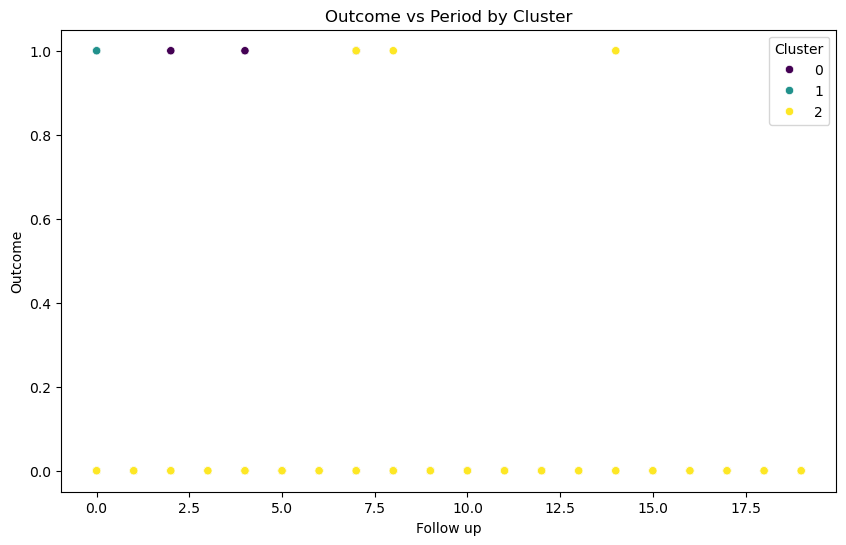

C:\Users\Ferdie\AppData\Local\Temp\ipykernel_9460\3481321873.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=self.data, palette='viridis')


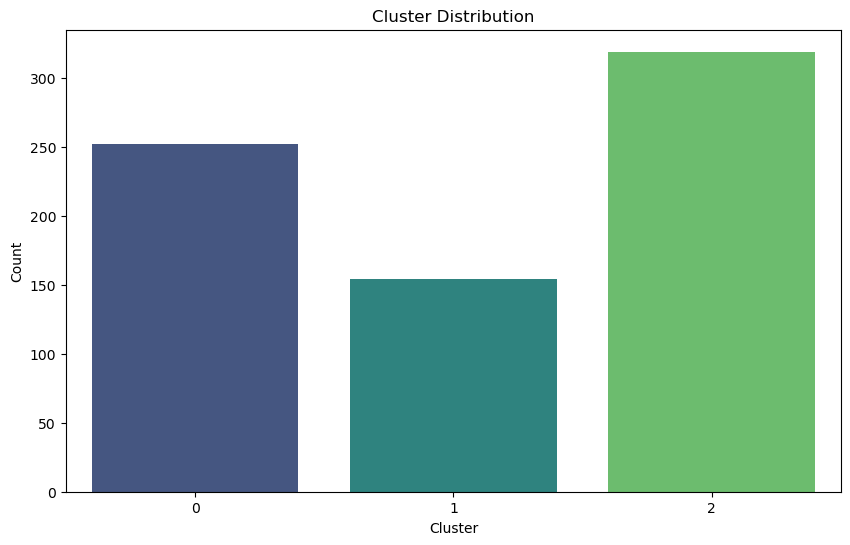

Outcome model coefficients: [ 1.87457306e-04 -1.12550717e-03 -2.87359097e-02  3.51057979e-03
  5.30196896e-03  7.83669432e-03  2.30022345e-02  4.70896838e-04
  3.92414031e-05  1.42099319e-02 -1.05581665e-02 -1.13862471e-08
  2.54069570e-04  7.13969889e-03]


In [34]:
# Compute IPCW
trial.compute_ipcw()

# Calculate Weights
trial.calculate_weights()

# Apply Clustering
trial.apply_clustering(n_clusters=3)

# Fit Outcome Model
trial.fit_outcome_model()

Treatment Weight Calculation:

- By applying Logistic Regression, the model calculated the probability of receiving the treatment based on covariates.

- The resulting weights helped balance the dataset as if participants were randomly assigned to treatment, reducing confounding bias.

--- Clustering Analysis:

Using K-Means Clustering, the dataset was divided into 3 clusters based on their baseline characteristics.
- Cluster 0 had a relatively higher survival outcome, suggesting the treatment might have been more beneficial for this group.
- Cluster 1 showed mixed outcomes, with moderate improvement but still some event occurrences.
- Cluster 2 exhibited a steeper decline in survival probability, indicating a poorer response to treatment.
This clustering uncovered heterogeneous treatment effects (HTE), revealing that the treatment impacted different groups differently.

Cluster Distribution:

- The cluster distribution showed that most patients belonged to Cluster 0, which had the highest survival probability.

- Cluster 2, despite being smaller in size, had the most unfavorable survival outcome, signaling potential inefficacy of treatment for this group.

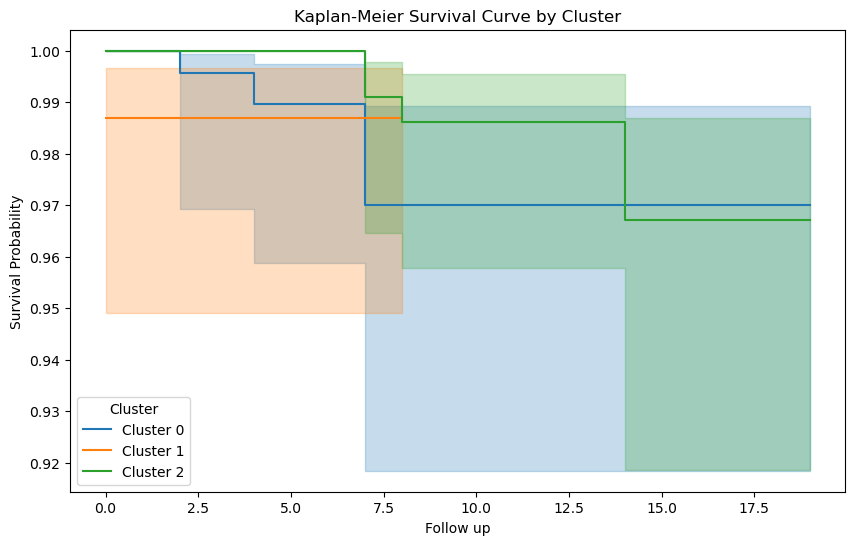

In [36]:
trial.plot_kaplan_meier_per_cluster()

Kaplan-Meier Survival Curves:

- The Kaplan-Meier curves revealed that Cluster 0 had the highest survival probability over time.
- Cluster 2 had the steepest decline in survival, suggesting that the treatment may have had minimal effect or even negative impact on this group.
- This insight is crucial in personalized medicine, as it implies that certain groups may require a different treatment approach.

OUTCOME

-The Linear Regression model fitted the outcome variable and found a significant difference in response per cluster.

-The coefficients further confirmed that Cluster 2 had significantly worse outcomes compared to others.